In [1]:
import numpy as np
from PIL import Image
import glob

#### 전체 사진중 최대 해상도 찾기

In [9]:
dirNames = ['Aiden', 'Andrew','Cathy']

(294, 265, 3)

In [16]:
widthRatio = []
heightRatio = []

for name in dirNames:
    # print(name)
    for file in sorted(glob.glob("../Data/Face/%s/*.jpg"%name)):
        # print(file)
        # break
        img = np.array(Image.open(file), dtype=np.int32)
        # print(img)
        # break
        widthRatio.append(img.shape[1])
        heightRatio.append(img.shape[0])

In [17]:
print("너비 최대 해상도 :", np.max(widthRatio))
print("높이 최대 해상도 :", np.max(heightRatio))

너비 최대 해상도 : 299
높이 최대 해상도 : 381


> 해상도의 크기를 400 * 300

##### 전체 사진을 400 * 300의 고정 크기로 검은색을 배경으로 맞추기

In [21]:
for name in dirNames:
    fileCount = 0
    for file in sorted(glob.glob("../Data/Face/%s/*.jpg"%name)):
        img = Image.open(file)
        img = img.convert('L')
        imgArray = np.array(img)

        imgDummy = np.zeros(400*300).reshape(400, 300)
        rowNum = (400 - imgArray.shape[0]) / 2
        colNum = (300 - imgArray.shape[1]) / 2

        k = 0
        for i in range(int(rowNum), int(rowNum)+imgArray.shape[0]):
            l = 0
            for j in range(int(colNum), int(colNum)+imgArray.shape[1]):
                imgDummy[i,j] = imgArray[k,l]
                l+=1
            k+=1
        
        img2 = Image.fromarray(imgDummy.astype('uint8'))
        img2.save("../Data/FaceGray/%s/image_%04d.jpg"%(name, fileCount), "JPEG")
        fileCount += 1

#### 사진들을 numpy배열로 Train Data 만들기

In [22]:
number_of_data = 18 * len(dirNames)
img_width_size = 300
img_height_size = 400

In [23]:
train = np.zeros(
            number_of_data*img_width_size*img_height_size, dtype=np.int32
        ).reshape(number_of_data, img_height_size, img_width_size) 

i = 0

for name in dirNames:
    for file in sorted(glob.glob("../Data/FaceGray/%s/*.jpg"%name)):
        img = np.array(Image.open(file), dtype=np.int32)
        train[i,:,:] = img
        i+=1


In [11]:
train.shape

(54, 400, 300)

#### 이미지 확인

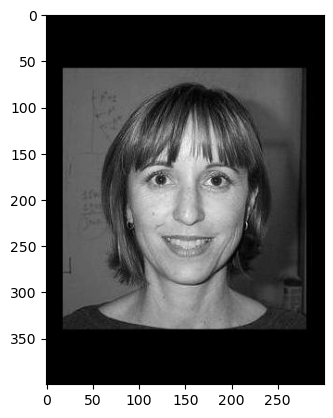

In [27]:
import matplotlib.pyplot as plt

# plt.imshow(train[40].reshape(400, 300), cmap='gray')
plt.imshow(train[40].reshape(400, 300),cmap='gray')
plt.show()

1
2
3


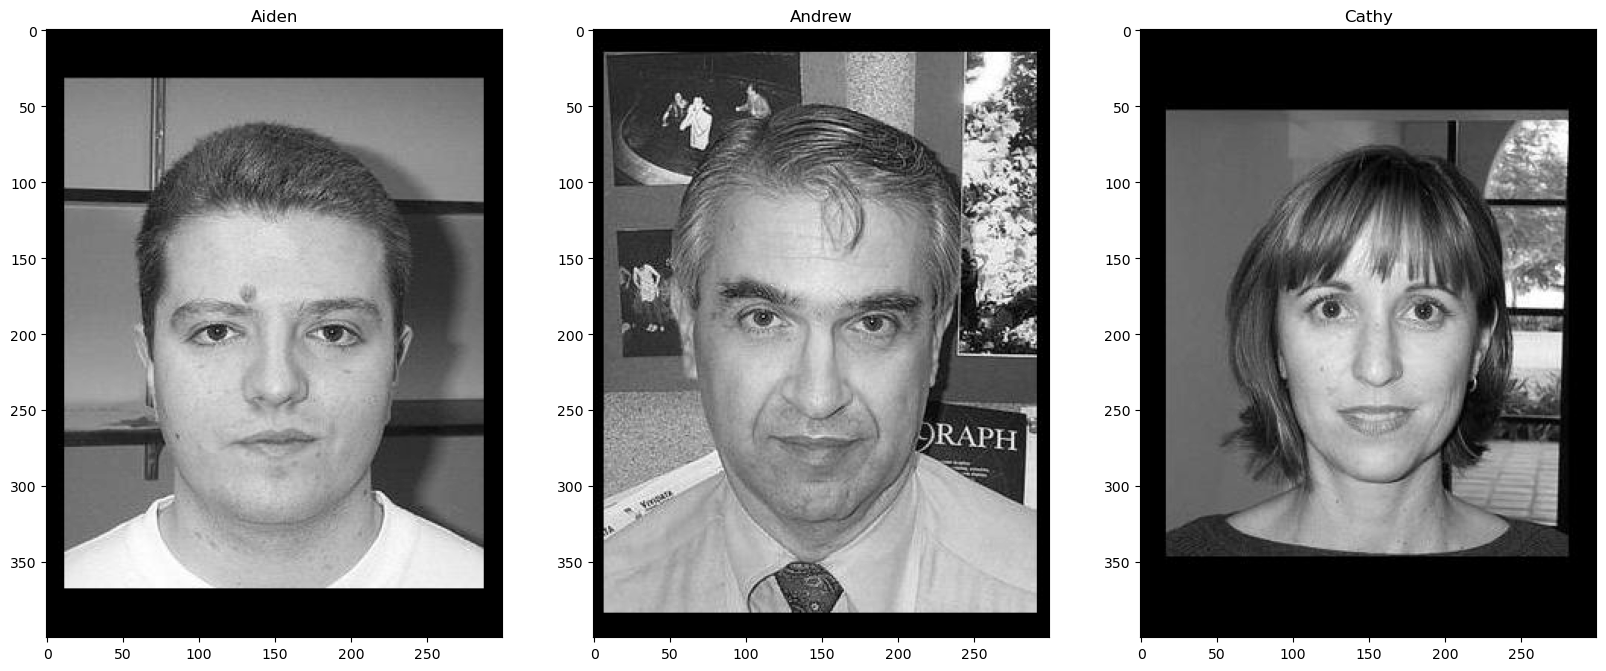

In [ ]:
plt.figure(figsize=(20, 20))
orderNo = list(range(0, len(dirNames)*18, 18))

for i in range(1, len(dirNames)+1):
    # print(i)
    plt.subplot(1, len(dirNames), i)
    plt.imshow(train[orderNo[i-1]].reshape(400, 300), cmap='gray')
    plt.title(dirNames[i-1])

#### target data 만들기

In [30]:
target = np.concatenate(
            [np.zeros(18), np.ones(18), np.full((18), 2)]
)
target

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2.])

#### 정규화

In [31]:
train = train.reshape(-1, 400, 300, 1) / 255.0

#### train과 test 분리

In [32]:
from sklearn.model_selection import train_test_split

trainData, testData, trainTarget, testTarget = \
                        train_test_split(
                            train,
                            target,
                            test_size=0.2,
                            random_state=42
                        )

In [33]:
print(trainData.shape)
print(testData.shape)
print(trainTarget.shape)
print(testTarget.shape)

(43, 400, 300, 1)
(11, 400, 300, 1)
(43,)
(11,)


#### CNN 만들기

In [34]:
from tensorflow import keras
from tensorflow.keras.layers import Input

In [21]:
model = keras.Sequential()

model.add(
    Input(shape=(400, 300, 1))
)

model.add(
    keras.layers.Conv2D(
        32,
        kernel_size=3,
        activation='relu',
        padding='same'
    )
)

model.add(
    keras.layers.MaxPooling2D(2)
)

model.add(
    keras.layers.Conv2D(
        64,
        kernel_size=3,
        activation='relu',
        padding='same'
    )
)

model.add(
    keras.layers.MaxPooling2D(2)
)


In [22]:
model.add(
    keras.layers.Flatten()
)

model.add(
    keras.layers.Dense(100, activation= 'relu')
)

model.add(
    keras.layers.Dropout(0.7)
)

model.add(
    keras.layers.Dense(
        len(dirNames),
        activation='softmax'
    )
)

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 400, 300, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 200, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 200, 150, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 100, 75, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │    48,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,019,219 (183.18 MB)

 Trainable params: 48,019,219 (183.18 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_cb = keras.callbacks.ModelCheckpoint("../Data/best_cnn_model3.keras")
early_stopping_cb = keras.callbacks.EarlyStopping(
                                patience=5,
                                restore_best_weights=True
)

In [25]:
history = model.fit(
                trainData,
                trainTarget,
                epochs=30,
                validation_data=(testData, testTarget),
                callbacks = [checkpoint_cb, early_stopping_cb]
)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3721 - loss: 5.0549 - val_accuracy: 0.6364 - val_loss: 0.9748
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5581 - loss: 6.2138 - val_accuracy: 0.7273 - val_loss: 1.0415
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7209 - loss: 1.9276 - val_accuracy: 0.9091 - val_loss: 0.1894
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6744 - loss: 1.5766 - val_accuracy: 0.9091 - val_loss: 0.3199
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8837 - loss: 0.3099 - val_accuracy: 0.9091 - val_loss: 0.4254
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9070 - loss: 0.3648 - val_accuracy: 0.9091 - val_loss: 0.2560
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9535 - loss: 0.1515 - val_accuracy: 0.9091 - val_loss: 0.3140
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9535 - loss: 0.2027 - val_accuracy: 0.9091 - val_loss: 0.3689


In [26]:
model.evaluate(trainData, trainTarget)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9535 - loss: 0.1090


[0.10901639610528946, 0.9534883499145508]

In [27]:
model.evaluate(testData, testTarget)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9091 - loss: 0.1894


[0.18938274681568146, 0.9090909361839294]

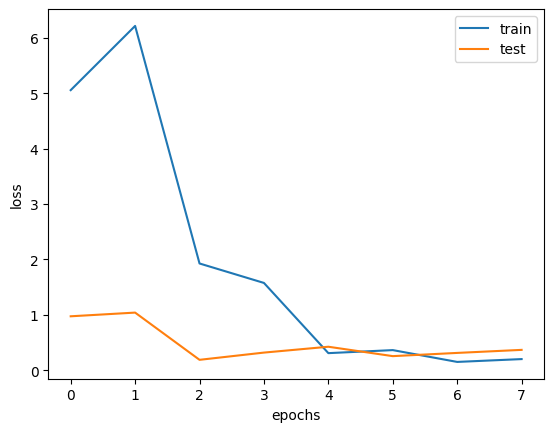

In [28]:
# 시각화 해보기
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()

#### 확인해 보기

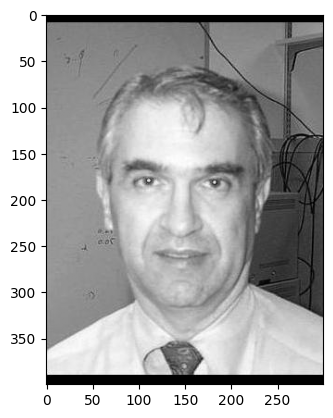

In [29]:
plt.imshow(testData[0].reshape(400, 300), cmap='gray')
plt.show()

In [30]:
model.predict(testData[0:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


array([[9.487369e-04, 9.982035e-01, 8.477477e-04]], dtype=float32)

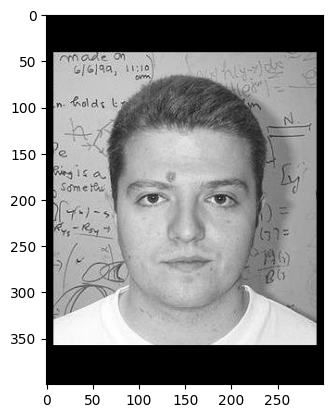

In [31]:
plt.imshow(testData[10].reshape(400, 300), cmap='gray')
plt.show()

In [35]:
model.predict(testData[10:11])

NameError: name 'model' is not defined